In [2]:
# Extract from https://github.com/StanfordVL/behavior/blob/main/behavior/benchmark/behavior_benchmark.py
import os
import bddl
import json
import behavior
import pyquaternion  
import numpy as np
from PIL import Image
from igibson.utils.utils import parse_config
from igibson.envs.igibson_env import iGibsonEnv
from igibson import object_states

from utils import get_env_config, render_robot_pov, render_360, render_robot_orientation_view


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
PHYSICS_STEPS = 50

scene_id =  "Benevolence_1_int"
task = "cleaning_out_drawers"
env_config = get_env_config()
env_config["scene_id"] = scene_id
env_config["task"] = task
env_config["task_id"] = 0
env_config["instance_id"] = 0

# Keep this in memory as it's removed from the config when we init iGibson - so we need to reload it
robot_name = env_config["robot"]["name"]

env = iGibsonEnv(
        config_file=env_config,
        mode="headless",
        action_timestep=1.0 / 30.0,
        physics_timestep=1.0 / 120.0,
    )

render_robot_pov(env, env_config, step='initial', show=False, save=False)

# Run some steps to let physics settle.
s = env.simulator
for _ in range(PHYSICS_STEPS):
    s.step()
    
render_robot_pov(env, env_config, step='initial', show=False, save=True)
render_360(env, show=False, save=False)

Rendering settings is None - going with the default settings!
																																																																						b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
left_hand_shoulderb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
right_hand_shoulderb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
neckb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data

## Navigate to obj

In [6]:
def print_properties(obj):
    """
    Requires from igibson import object_states
    """
    logic_state = {}
    state_keys = ['InFOVOfRobot', 'InSameRoomAsRobot', 'InReachOfRobot']

    logic_state = {key: obj.states[getattr(object_states, key)].get_value() for key in state_keys}

    print(logic_state)

In [7]:
# Go to cabinet 1
from igibson.action_primitives.starter_semantic_action_primitives import StarterSemanticActionPrimitives

scene = env.scene
s = env.simulator
robot = env.robots[0]
controller = StarterSemanticActionPrimitives(None, scene, robot)
obj = env.task.object_scope['sink.n.01_1']
#obj = env.task.object_scope['cabinet.n.01_1']
#obj = env.task.object_scope['cabinet.n.01_2']

# Show before
render_robot_pov(env, env_config, step='before', show=True, save=True)
#print("Joints velocities before teleport: ", robot._joint_state['unnormalized']['velocity'])
print_properties(obj)
controller.teleport_near_obj(obj, env)
#robot_pos, original_orientation = robot.get_position_orientation() # does it work reliably?
#print("Joints velocities after teleport: ", robot._joint_state['unnormalized']['velocity'])

# Run some steps to let physics settle.
s = env.simulator
for _ in range(PHYSICS_STEPS):
    print_properties(obj)
    #print(f"Joints velocities after step {_}: ", robot._joint_state['unnormalized']['velocity']) # doesn't help
    #robot_pos, robot_orientation = robot.get_position_orientation()
    #print("robot_pos: ", robot_pos)
    #print("robot_orientation: ", robot_orientation)
    render_robot_pov(env, env_config, step=f'{_}', show=False, save=True)
    #render_robot_orientation_view(env, original_orientation, env_config, step=f'{_}', show=False, save=True)
    s.step()
    
# Show after -> works only if we save the original orientation 
# Is this enough, or do we want to try and force it on the robot?
#render_robot_orientation_view(env, original_orientation, env_config, step='after_original_view', show=True, save=True)
render_robot_pov(env, env_config, step='after', show=True, save=True)
print_properties(obj)

The StarterSemanticActionPrimitive is a work-in-progress and is only provided as an example. It currently only works with BehaviorRobot with its JointControllers set to absolute mode. See provided behavior_robot_mp_behavior_task.yaml config file for an example. See examples/action_primitives for runnable examples.


{'InFOVOfRobot': True, 'InSameRoomAsRobot': True, 'InReachOfRobot': True}
                                                    
Attempt: 0
[1.06949759 0.15673456 0.40185618] [0.76599981 0.14623087 0.20181183]
Yaw:  2.6433504039301816 151.45282191940078
New yaw:  -0.3676645028539853 -21.065624290308968
                                                      Candidate position failed shoulder distance test.
                                                    
Attempt: 1
[1.06949759 0.15673456 0.40185618] [0.76599981 0.24854689 0.25613015]
Yaw:  1.5078617704148982 86.39411553389796
New yaw:  -1.153115584736312 -66.06865629615072
                                                        Start collision test.
                                                        Body has collision with objects %s [41]
                                                        Left hand has collision with objects %s [41]
                                                        Right hand has collision with objects 

## Let's just put a blue dot over the right object

In [8]:
#obj_pos, obj_orn = obj.get_position_orientation()
#obj_pos

# Let's get multiple objects over the surface - in which frame are these?
# see from get_center_extent -should be in the world frame of reference
positions_on_obj_surface = []
for i in range(1000):
    pos_on_obj_surface = controller._sample_position_on_aabb_face(obj)
    positions_on_obj_surface.append(pos_on_obj_surface)

In [9]:
# Set camera to position that will be used for the bounding box! Otherwise we're going to have a mismatch
robot_pos, robot_orientation = robot.get_position_orientation()

# Convert quaternion to rotation matrix - takes w,x,y,z in input, but robot orientation is given as x,y,z,w !!!
q = pyquaternion.Quaternion(x=robot_orientation[0], 
                            y=robot_orientation[1], 
                            z=robot_orientation[2], 
                            w=robot_orientation[3])

forward_downward_direction = q.rotate(np.array([1, 0, -0.25]))  # Default forward vector (x-axis)
up_direction = q.rotate(np.array([0, 0, 1]))  # Default up vector (z-axis)

# Set the camera at the robot's head level (optional: raise it slightly)
camera_pose = robot_pos + q.rotate(np.array([0.1, 0.1, 1])) # Slightly above the robot's center
print(camera_pose)

# Set the camera in the renderer
s.renderer.set_camera(camera_pose, camera_pose + forward_downward_direction, up_direction)
s.renderer.set_fov(90)

[0.4846981  0.18216528 1.55      ]


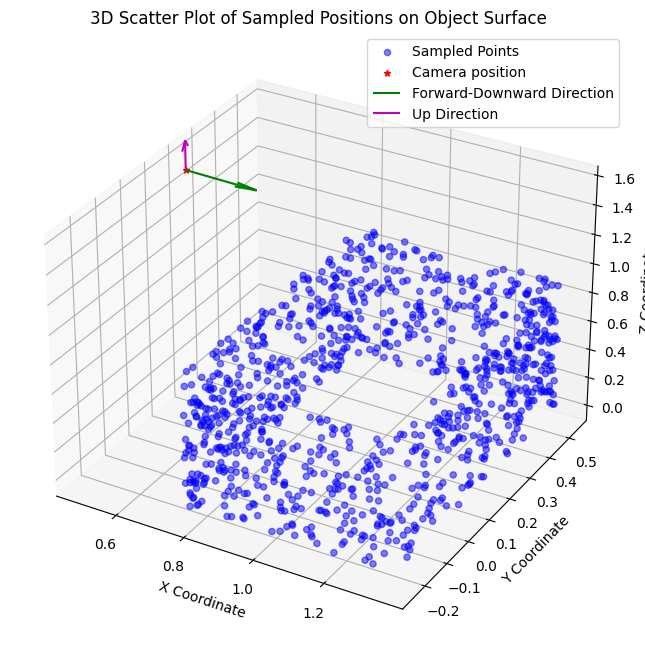

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Let's visualize the xyz coordinates as a 3D scatter plot
xyz = np.stack(positions_on_obj_surface)  # Shape (1000, 3)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='b', marker='o', alpha=0.5, label="Sampled Points")

ax.scatter(camera_pose[0], camera_pose[1], camera_pose[2], c='r', marker='*', label='Camera position')

# Add arrows for forward_downward_direction and up_direction
arrow_scale = 0.2  # Adjust for visibility

ax.quiver(camera_pose[0], camera_pose[1], camera_pose[2], 
          forward_downward_direction[0], forward_downward_direction[1], forward_downward_direction[2], 
          color='g', length=arrow_scale, normalize=True, label="Forward-Downward Direction")

ax.quiver(camera_pose[0], camera_pose[1], camera_pose[2], 
          up_direction[0], up_direction[1], up_direction[2], 
          color='m', length=arrow_scale, normalize=True, label="Up Direction")

# Labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Scatter Plot of Sampled Positions on Object Surface")


ax.legend()
plt.show()


In [11]:
# Assuming is in world coordinates - move point to camera frame coordinates
# This is the most likely step to be wrong? Sanity check for camera works though!
objects_pos_camera_frame = [s.renderer.transform_point(obj_pos) for obj_pos in positions_on_obj_surface]
objects_pos_camera_frame = np.stack(objects_pos_camera_frame)

In [12]:
# Transform the two directions forward_downward and up
forward_downward_direction_cf = s.renderer.transform_vector(forward_downward_direction)
up_direction_cf = s.renderer.transform_vector(up_direction)

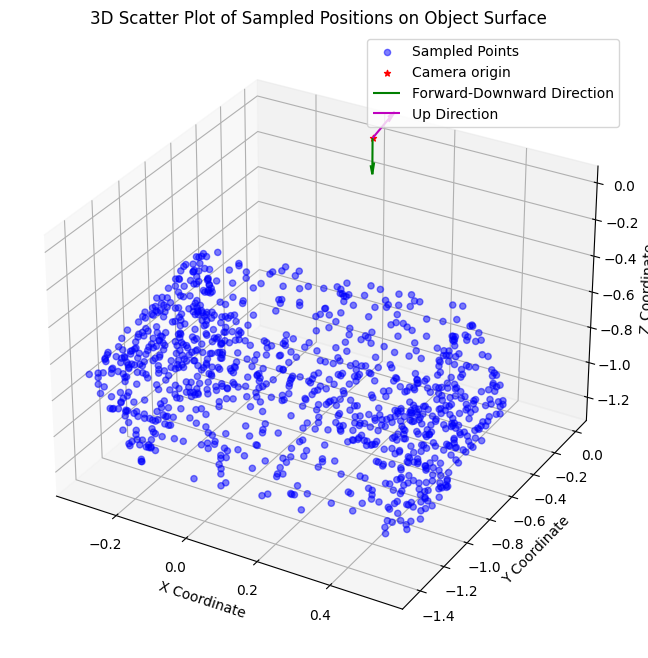

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Let's visualize the xyz coordinates as a 3D scatter plot
xyz = objects_pos_camera_frame  # Shape (1000, 3)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='b', marker='o', alpha=0.5, label="Sampled Points")

ax.scatter(0,0,0, c='r', marker='*', label='Camera origin')

# Add arrows for forward_downward_direction and up_direction
arrow_scale = 0.2  # Adjust for visibility

ax.quiver(0, 0, 0, 
          forward_downward_direction_cf[0], forward_downward_direction_cf[1], forward_downward_direction_cf[2], 
          color='g', length=arrow_scale, normalize=True, label="Forward-Downward Direction")

ax.quiver(0, 0, 0, 
          up_direction_cf[0], up_direction_cf[1], up_direction_cf[2], 
          color='m', length=arrow_scale, normalize=True, label="Up Direction")

# Labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Scatter Plot of Sampled Positions on Object Surface")

# Optional: Set limits for better visualization
#ax.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
#ax.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
#ax.set_zlim(np.min(xyz[:, 2]), np.max(xyz[:, 2]))

ax.legend()
plt.show()

In [14]:
# Project to uv plane
K = s.renderer.get_intrinsics()
print(K) # this is likely correct, as it has such interpretable parameters
uvw_column_vectors = np.dot(K, objects_pos_camera_frame.T)
print('uvw_column_vectors.shape', uvw_column_vectors.shape)
uv_prime_column_vectors = uvw_column_vectors[:2]/uvw_column_vectors[2:]
uv_prime = uv_prime_column_vectors.T

[[540.   0. 540.]
 [  0. 540. 540.]
 [  0.   0.   1.]]
uvw_column_vectors.shape (3, 1000)


In [15]:
env.simulator.image_width

1080

In [17]:
from PIL import ImageDraw

frame = s.renderer.render(modes=("rgb"))[0]
rgb_image = (frame[..., :3] * 255).astype(np.uint8) 

# Save using PIL
image = Image.fromarray(rgb_image)
draw = ImageDraw.Draw(image)

U = env.simulator.image_width
# Draw point
for (u,v) in uv_prime:
    r = 3  # Radius of the circle
    draw.ellipse([(U - u - r, v - r), (U - u + r, v + r)], fill="blue", outline="blue")
    
image.show()
image.save("images/tmp.jpg", "JPEG")

### Sanity checks

What happens to the camera position in the world frame when I transform the point in the camera frame? Does it go to (0,0,0)?

In [20]:
# wf = world frame, cf = camera frame
camera_position_wf = camera_pose
print("Camera position in world frame coord: ", camera_position_wf)
camera_position_cf = s.renderer.transform_point(camera_position_wf) # this seems to work more or less
print("Camera position in camera frame coord: ", camera_position_cf)
world_origin_wf = np.array([0,0,0])
print("World origin position in world frame coord: ", world_origin_wf)
world_origin_cf = s.renderer.transform_point(world_origin_wf)
print("World origin position in camera frame coord: ", world_origin_cf)


Camera position in world frame coord:  [0.08912896 0.21174302 1.55      ]
Camera position in camera frame coord:  [ 9.83580231e-10  5.81659552e-08 -1.39462965e-08]
World origin position in world frame coord:  [0 0 0]
World origin position in camera frame coord:  [ 0.20129879 -1.47686839 -0.48333979]


In [21]:
print(camera_pose) 
print(camera_pose + forward_downward_direction)
print(up_direction)

[0.08912896 0.21174302 1.55      ]
[ 0.70974746 -0.57236965  1.3       ]
[1.05176680e-16 8.32464467e-17 1.00000000e+00]


## Render bounding boxes around task's objects

In [9]:
# see https://github.com/StanfordVL/iGibson/blob/master/igibson/examples/objects/draw_bounding_box.py

In [48]:
import trimesh
import itertools
from igibson.utils import utils as ig_utils
import pybullet as p 

visible = obj.states[object_states.InFOVOfRobot].get_value() 
print(f"Object is visible: {visible}")

#bbox_center, bbox_orn, bbox_bf_extent, bbox_wf_extent = obj.get_base_aligned_bounding_box(visual=True)
bbox_center_in_world, bbox_orn_in_world, bbox_extent_in_desired_frame, bbox_center_in_desired_frame  = obj.get_base_aligned_bounding_box(visual=True) 
print('bbox_center_in_world', bbox_center_in_world)
print('bbox_orn_in_world', bbox_orn_in_world)
# What is the desired frame??? -> Center of Mass frame
print('bbox_extent_in_desired_frame', bbox_extent_in_desired_frame)
print('bbox_center_in_desired_frame', bbox_center_in_desired_frame)

Object is visible: True
bbox_center_in_world [1.05994913 0.145      0.44992262]
bbox_orn_in_world [ 0.          0.         -0.70710663  0.70710693]
bbox_extent_in_desired_frame [0.76950285 0.57980715 0.89063036]
bbox_center_in_desired_frame [ 0.01173455 -0.00954846  0.04806644]


In [115]:
# Define the 3D bounding box corners - 8 corners in 3D space - does this make it a cube? I think not, because the 3 dimensions have different multipliers
bbox_frame_vertex_positions = np.array(list(itertools.product((1, -1), repeat=3))) * (
    bbox_extent_in_desired_frame / 2
) + bbox_center_in_desired_frame
print('bbox_frame_vertex_positions \n', bbox_frame_vertex_positions)

# Trasform corners to world coordinates by applying the translation + rotation - how can I know that it's correct?

# 1. Convert position and quaternion to transformation matrix
bbox_transform = ig_utils.quat_pos_to_mat(bbox_center_in_world, bbox_orn_in_world) 
print("bbox_transform.shape: ", bbox_transform.shape)
print('bbox_transform \n', bbox_transform)

world_frame_vertex_positions = trimesh.transformations.transform_points(
    bbox_frame_vertex_positions, bbox_transform
)
print("world_frame_vertex_positions: \n", world_frame_vertex_positions)# Compute the rotation matrix using the quaternion

# Here, we assume bbox_orn_in_world is in (x, y, z, w) order. - how do we know if it's the right order??
q = pyquaternion.Quaternion(x=bbox_orn_in_world[0], 
                            y=bbox_orn_in_world[1], 
                            z=bbox_orn_in_world[2], 
                            w=bbox_orn_in_world[3])
rotation_matrix = q.rotation_matrix  # This is a 3x3 matrix

# Manually apply rotation and translation:
world_frame_vertex_positions = (bbox_frame_vertex_positions @ rotation_matrix.T) + bbox_center_in_world
print("world_frame_vertex_positions (manual): \n", world_frame_vertex_positions)

bbox_frame_vertex_positions 
 [[ 0.39648598  0.28035511  0.49338162]
 [ 0.39648598  0.28035511 -0.39724874]
 [ 0.39648598 -0.29945204  0.49338162]
 [ 0.39648598 -0.29945204 -0.39724874]
 [-0.37301688  0.28035511  0.49338162]
 [-0.37301688  0.28035511 -0.39724874]
 [-0.37301688 -0.29945204  0.49338162]
 [-0.37301688 -0.29945204 -0.39724874]]
bbox_transform.shape:  (4, 4)
bbox_transform 
 [[ 4.21468510e-07  1.00000000e+00  0.00000000e+00  1.05994913e+00]
 [-1.00000000e+00  4.21468510e-07 -0.00000000e+00  1.45000002e-01]
 [-0.00000000e+00  0.00000000e+00  1.00000000e+00  4.49922621e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
world_frame_vertex_positions: 
 [[ 1.34030441 -0.25148586  0.94330424]
 [ 1.34030441 -0.25148586  0.05267388]
 [ 0.76049726 -0.2514861   0.94330424]
 [ 0.76049726 -0.2514861   0.05267388]
 [ 1.34030409  0.518017    0.94330424]
 [ 1.34030409  0.518017    0.05267388]
 [ 0.76049693  0.51801675  0.94330424]
 [ 0.76049693  0.51801675  0.0526738

In [116]:
# Set camera to position that will be used for the bounding box! Otherwise we're going to have a mismatch
robot_pos, robot_orientation = robot.get_position_orientation()

# Convert quaternion to rotation matrix - takes w,x,y,z in input, but robot orientation is given as x,y,z,w !!!
q = pyquaternion.Quaternion(x=robot_orientation[0], 
                            y=robot_orientation[1], 
                            z=robot_orientation[2], 
                            w=robot_orientation[3])

forward_downward_direction = q.rotate(np.array([1, 0, -0.25]))  # Default forward vector (x-axis)
up_direction = q.rotate(np.array([0, 0, 1]))  # Default up vector (z-axis)

# Set the camera at the robot's head level (optional: raise it slightly)
camera_pose = robot_pos + q.rotate(np.array([0.1, 0.1, 1])) # Slightly above the robot's center

# Set the camera in the renderer
s.renderer.set_camera(camera_pose, camera_pose + forward_downward_direction, up_direction)
s.renderer.set_fov(90)

In [117]:
# Does setting the camera changes the outcome of the following function? Yes it does
camera_frame_vertex_positions = np.array([s.renderer.transform_point(v) for v in world_frame_vertex_positions]) # still 3d!!
print("camera_frame_vertex_positions: \n", camera_frame_vertex_positions)
#bbox_orn_camera = s.renderer.transform_pose(bbox_orn) - might be broken
#print(bbox_orn_camera)

camera_frame_vertex_positions: 
 [[-1.22247772 -0.02824842 -2.38847702]
 [-1.22247772 -0.89228677 -2.60448657]
 [-0.88693993 -0.1429323  -1.92974142]
 [-0.88693993 -1.00697065 -2.14575097]
 [-1.85003528 -0.13625334 -1.95645727]
 [-1.85003528 -1.00029169 -2.17246682]
 [-1.5144975  -0.25093721 -1.49772167]
 [-1.5144975  -1.11497556 -1.71373122]]


In [118]:
K = s.renderer.get_intrinsics()
print('K \n', K)

K 
 [[540.   0. 540.]
 [  0. 540. 540.]
 [  0.   0.   1.]]


In [119]:
uvw_column_vectors = np.dot(K, camera_frame_vertex_positions.T)
print(uvw_column_vectors.T)
uv_prime_column_vectors = uvw_column_vectors[:2]/uvw_column_vectors[2:]
uv_prime = uv_prime_column_vectors.T
print(uv_prime.shape)
print(uv_prime)

[[-1.94991556e+03 -1.30503174e+03 -2.38847702e+00]
 [-2.06656071e+03 -1.88825760e+03 -2.60448657e+00]
 [-1.52100793e+03 -1.11924381e+03 -1.92974142e+00]
 [-1.63765309e+03 -1.70246967e+03 -2.14575097e+00]
 [-2.05550598e+03 -1.13006373e+03 -1.95645727e+00]
 [-2.17215113e+03 -1.71328959e+03 -2.17246682e+00]
 [-1.62659835e+03 -9.44275797e+02 -1.49772167e+00]
 [-1.74324351e+03 -1.52750166e+03 -1.71373122e+00]]
(8, 2)
[[ 816.38447482  546.386559  ]
 [ 793.46184351  725.00185945]
 [ 788.19261262  579.99677909]
 [ 763.20743274  793.41437932]
 [1050.62656321  577.60716076]
 [ 999.85468864  788.637865  ]
 [1086.04848543  630.47481755]
 [1017.22107254  891.33094189]]


In [120]:
u_max, v_max = uv_prime.max(axis=0)
u_min, v_min = uv_prime.min(axis=0)

print(u_max, u_min, v_max, v_min)

1086.0484854287465 763.2074327359236 891.3309418897617 546.386559002358


In [121]:
from PIL import ImageDraw

frame = s.renderer.render(modes=("rgb"))[0]
rgb_image = (frame[..., :3] * 255).astype(np.uint8) 

# Save using PIL
image = Image.fromarray(rgb_image)
draw = ImageDraw.Draw(image)

# Draw all 8 points
for i in range(8):
    u, v = uv_prime[i]
    r = 5  # Radius of the circle
    draw.ellipse([(u - r, v - r), (u + r, v + r)], fill="blue", outline="blue")
    
# Draw the bounding box. You can adjust the outline color and width as needed.
draw.rectangle([(u_min, v_min), (u_max, v_max)], outline="red", width=3)
#draw.rectangle([(v_min, u_min), (v_max, u_max)], outline="red", width=3)
image.show()

## Alternative computation

In [65]:
# Convert world points to homogeneous coordinates:
world_points_h = np.hstack((world_frame_vertex_positions, np.ones((world_frame_vertex_positions.shape[0], 1))))

# Compute camera frame coordinates:
camera_points_h = (s.renderer.V @ world_points_h.T).T  # Each row is a homogeneous point in camera space
camera_points_h

array([[ 0.56890081, -0.41037705, -0.85996199,  1.        ],
       [ 0.56890081, -1.2744154 , -1.07597154,  1.        ],
       [ 0.4019786 , -0.54504728, -0.32128098,  1.        ],
       [ 0.4019786 , -1.40908563, -0.53729053,  1.        ],
       [-0.16802338, -0.35664713, -1.07488173,  1.        ],
       [-0.16802338, -1.22068548, -1.29089128,  1.        ],
       [-0.33494558, -0.49131735, -0.53620072,  1.        ],
       [-0.33494558, -1.3553557 , -0.75221027,  1.        ]])

In [70]:
# Normalize if necessary (usually w should be 1 after applying V)
camera_points = camera_points_h[:, :3]

In [71]:
# Extract intrinsic parameters from K:
K = s.renderer.get_intrinsics()
fu = K[0, 0]
fv = K[1, 1]
u0 = K[0, 2]
v0 = K[1, 2]

uv_points = []
for pt in camera_points:
    x_cam, y_cam, z_cam = pt
    # Check that the point is in front of the camera (z_cam should be negative)
    if z_cam >= 0:
        uv_points.append([np.nan, np.nan])  # or handle points behind the camera appropriately
    else:
        u = fu * (x_cam / -z_cam) + u0
        v = fv * (y_cam / -z_cam) + v0
        uv_points.append([u, v])
uv_prime = np.array(uv_points)
uv_prime

array([[ 897.23257249,  282.30999886],
       [ 825.51539104,  -99.59341759],
       [1215.63428533, -376.10007114],
       [ 944.00571884, -876.19142236],
       [ 455.58827373,  360.82731256],
       [ 469.71319584,   29.3681853 ],
       [ 202.68114729,   45.20138909],
       [ 299.54780258, -432.988686  ]])

In [72]:
u_max, v_max = uv_prime.max(axis=0)
u_min, v_min = uv_prime.min(axis=0)

print(u_max, u_min, v_max, v_min)

1215.6342853328802 202.68114729144668 360.82731256346347 -876.1914223601816


In [73]:
from PIL import ImageDraw

frame = s.renderer.render(modes=("rgb"))[0]
rgb_image = (frame[..., :3] * 255).astype(np.uint8) 

# Save using PIL
image = Image.fromarray(rgb_image)
draw = ImageDraw.Draw(image)

# Draw all 8 points
for i in range(8):
    u, v = uv_prime[i]
    r = 5  # Radius of the circle
    draw.ellipse([(u - r, v - r), (u + r, v + r)], fill="blue", outline="blue")
    
# Draw the bounding box. You can adjust the outline color and width as needed.
draw.rectangle([(u_min, v_min), (u_max, v_max)], outline="red", width=3)
#draw.rectangle([(v_min, u_min), (v_max, u_max)], outline="red", width=3)
image.show()

## Get list of objects and compute some predicates

In [18]:
object_names_list = list(env.task.object_scope.keys())
print("object_names_list: ", object_names_list)

object_names_list:  ['bowl.n.01_1', 'bowl.n.01_2', 'cabinet.n.01_1', 'cabinet.n.01_2', 'spoon.n.01_1', 'spoon.n.01_2', 'piece_of_cloth.n.01_1', 'sink.n.01_1', 'floor.n.01_1', 'agent.n.01_1']


In [20]:
object_names_list = list(env.task.object_scope.keys())
print("object_names_list: ", object_names_list)

filtered_object_names_list = [name for name in object_names_list \
                              if name.split('.')[0] not in ['agent', 'floor']]
print("filtered_object_names_list: ", filtered_object_names_list)

for name in filtered_object_names_list:
    print(f"Name: {name}")
    obj = env.task.object_scope[name]
    print_properties(obj)

object_names_list:  ['bowl.n.01_1', 'bowl.n.01_2', 'cabinet.n.01_1', 'cabinet.n.01_2', 'spoon.n.01_1', 'spoon.n.01_2', 'piece_of_cloth.n.01_1', 'sink.n.01_1', 'floor.n.01_1', 'agent.n.01_1']
filtered_object_names_list:  ['bowl.n.01_1', 'bowl.n.01_2', 'cabinet.n.01_1', 'cabinet.n.01_2', 'spoon.n.01_1', 'spoon.n.01_2', 'piece_of_cloth.n.01_1', 'sink.n.01_1']
Name: bowl.n.01_1
{'InFOVOfRobot': True, 'InSameRoomAsRobot': False, 'InReachOfRobot': True}
Name: bowl.n.01_2
{'InFOVOfRobot': True, 'InSameRoomAsRobot': False, 'InReachOfRobot': True}
Name: cabinet.n.01_1
{'InFOVOfRobot': False, 'InSameRoomAsRobot': True, 'InReachOfRobot': True}
Name: cabinet.n.01_2
{'InFOVOfRobot': False, 'InSameRoomAsRobot': True, 'InReachOfRobot': True}
Name: spoon.n.01_1
{'InFOVOfRobot': False, 'InSameRoomAsRobot': False, 'InReachOfRobot': True}
Name: spoon.n.01_2
{'InFOVOfRobot': False, 'InSameRoomAsRobot': False, 'InReachOfRobot': True}
Name: piece_of_cloth.n.01_1
{'InFOVOfRobot': False, 'InSameRoomAsRobot': 

In [22]:
bowl1 = env.task.object_scope['bowl.n.01_1']
cabinet1 = env.task.object_scope['cabinet.n.01_1']
bowl1.states[object_states.inside.Inside].get_value(cabinet1)

True

## Old code

In [ ]:

# Old code containing navitagion to object
#for i, action in enumerate(ctrl_gen):
#    robot.apply_action(action)
#    s.step()
#    if i+1 % 100 == 0:
#        print(f"Executing action {action} at step {i}")
#        render_robot_pov(env, env_config, i)